In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df = pd.read_excel("key descriptor.xlsx")
X = df.drop(columns=["name", "Risk_Level"])
y = df["Risk_Level"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_binarized = label_binarize(y_encoded, classes=[0, 1, 2])

In [3]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X.values, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_valid = scaler.transform(X_valid).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

def objective(trial):
    params = {
        "n_d": trial.suggest_int("n_d", 8, 64),
        "n_a": trial.suggest_int("n_a", 8, 64),
        "n_steps": trial.suggest_int("n_steps", 3, 10),
        "gamma": trial.suggest_float("gamma", 1.0, 2.0),
        "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True),
        "momentum": trial.suggest_float("momentum", 0.01, 0.4),
        "optimizer_params": {"lr": trial.suggest_float("lr", 1e-4, 1e-2, log=True)},
    }

    model = TabNetClassifier(**params, seed=42)

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_name=["valid"],
        eval_metric=["accuracy"],
        max_epochs=100,
        patience=10,
        batch_size=256,
        virtual_batch_size=128,
    )

    preds = model.predict(X_valid)
    return accuracy_score(y_valid, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best trial:")
print(study.best_trial.params)


[I 2025-09-11 19:32:16,585] A new study created in memory with name: no-name-4e3326cf-9f17-4837-8d10-7f90f8a30fe6
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.29716 | valid_accuracy: 0.67041 |  0:00:02s
epoch 1  | loss: 0.76316 | valid_accuracy: 0.72659 |  0:00:04s
epoch 2  | loss: 0.67229 | valid_accuracy: 0.76404 |  0:00:06s
epoch 3  | loss: 0.57534 | valid_accuracy: 0.76404 |  0:00:08s
epoch 4  | loss: 0.56721 | valid_accuracy: 0.8015  |  0:00:10s
epoch 5  | loss: 0.51078 | valid_accuracy: 0.80899 |  0:00:12s
epoch 6  | loss: 0.48076 | valid_accuracy: 0.81273 |  0:00:15s
epoch 7  | loss: 0.47605 | valid_accuracy: 0.83146 |  0:00:18s
epoch 8  | loss: 0.49678 | valid_accuracy: 0.77154 |  0:00:20s
epoch 9  | loss: 0.45354 | valid_accuracy: 0.8427  |  0:00:23s
epoch 10 | loss: 0.41175 | valid_accuracy: 0.82397 |  0:00:25s
epoch 11 | loss: 0.4349  | valid_accuracy: 0.85393 |  0:00:28s
epoch 12 | loss: 0.39226 | valid_accuracy: 0.86891 |  0:00:31s
epoch 13 | loss: 0.38892 | valid_accuracy: 0.83146 |  0:00:33s
epoch 14 | loss: 0.38553 | valid_accuracy: 0.8427  |  0:00:35s
epoch 15 | loss: 0.35363 | valid_accuracy: 0.83521 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 19:33:17,287] Trial 0 finished with value: 0.8689138576779026 and parameters: {'n_d': 56, 'n_a': 62, 'n_steps': 5, 'gamma': 1.6283125723779606, 'lambda_sparse': 0.00026547379905923573, 'momentum': 0.2141502087722307, 'lr': 0.005686551208691206}. Best is trial 0 with value: 0.8689138576779026.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.48158 | valid_accuracy: 0.62172 |  0:00:04s
epoch 1  | loss: 1.35175 | valid_accuracy: 0.69663 |  0:00:09s
epoch 2  | loss: 0.89411 | valid_accuracy: 0.72659 |  0:00:14s
epoch 3  | loss: 0.77281 | valid_accuracy: 0.75281 |  0:00:18s
epoch 4  | loss: 0.66663 | valid_accuracy: 0.74532 |  0:00:23s
epoch 5  | loss: 0.83465 | valid_accuracy: 0.78652 |  0:00:27s
epoch 6  | loss: 0.65634 | valid_accuracy: 0.75655 |  0:00:31s
epoch 7  | loss: 0.60627 | valid_accuracy: 0.80899 |  0:00:36s
epoch 8  | loss: 0.59989 | valid_accuracy: 0.82022 |  0:00:40s
epoch 9  | loss: 0.57505 | valid_accuracy: 0.74532 |  0:00:45s
epoch 10 | loss: 0.57269 | valid_accuracy: 0.82772 |  0:00:49s
epoch 11 | loss: 0.61798 | valid_accuracy: 0.78652 |  0:00:53s
epoch 12 | loss: 0.54201 | valid_accuracy: 0.82397 |  0:00:57s
epoch 13 | loss: 0.55475 | valid_accuracy: 0.83895 |  0:01:02s
epoch 14 | loss: 0.5374  | valid_accuracy: 0.86142 |  0:01:06s
epoch 15 | loss: 0.50047 | valid_accuracy: 0.80524 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 19:35:08,973] Trial 1 finished with value: 0.8614232209737828 and parameters: {'n_d': 57, 'n_a': 47, 'n_steps': 10, 'gamma': 1.0576233289046013, 'lambda_sparse': 0.0009254896500150499, 'momentum': 0.03206225653777706, 'lr': 0.006704639899330909}. Best is trial 0 with value: 0.8689138576779026.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.03888 | valid_accuracy: 0.43071 |  0:00:02s
epoch 1  | loss: 1.86464 | valid_accuracy: 0.44195 |  0:00:05s
epoch 2  | loss: 1.78008 | valid_accuracy: 0.43071 |  0:00:08s
epoch 3  | loss: 1.78404 | valid_accuracy: 0.49438 |  0:00:10s
epoch 4  | loss: 1.63236 | valid_accuracy: 0.46816 |  0:00:13s
epoch 5  | loss: 1.42293 | valid_accuracy: 0.53184 |  0:00:16s
epoch 6  | loss: 1.38305 | valid_accuracy: 0.603   |  0:00:19s
epoch 7  | loss: 1.34605 | valid_accuracy: 0.58427 |  0:00:21s
epoch 8  | loss: 1.18807 | valid_accuracy: 0.61049 |  0:00:24s
epoch 9  | loss: 1.13517 | valid_accuracy: 0.67041 |  0:00:26s
epoch 10 | loss: 1.10271 | valid_accuracy: 0.62547 |  0:00:30s
epoch 11 | loss: 0.9452  | valid_accuracy: 0.67416 |  0:00:33s
epoch 12 | loss: 0.95046 | valid_accuracy: 0.69663 |  0:00:36s
epoch 13 | loss: 0.90975 | valid_accuracy: 0.61049 |  0:00:38s
epoch 14 | loss: 0.82452 | valid_accuracy: 0.70787 |  0:00:41s
epoch 15 | loss: 0.87283 | valid_accuracy: 0.69663 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 19:36:52,877] Trial 2 finished with value: 0.7827715355805244 and parameters: {'n_d': 38, 'n_a': 45, 'n_steps': 6, 'gamma': 1.7911377406083104, 'lambda_sparse': 8.861992715625272e-05, 'momentum': 0.3827757450563667, 'lr': 0.0006688582201869728}. Best is trial 0 with value: 0.8689138576779026.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.31721 | valid_accuracy: 0.3221  |  0:00:03s
epoch 1  | loss: 2.92239 | valid_accuracy: 0.42697 |  0:00:07s
epoch 2  | loss: 2.71238 | valid_accuracy: 0.41199 |  0:00:11s
epoch 3  | loss: 2.49668 | valid_accuracy: 0.4382  |  0:00:14s
epoch 4  | loss: 2.31106 | valid_accuracy: 0.4794  |  0:00:17s
epoch 5  | loss: 2.13651 | valid_accuracy: 0.46442 |  0:00:21s
epoch 6  | loss: 1.99183 | valid_accuracy: 0.55431 |  0:00:24s
epoch 7  | loss: 1.87442 | valid_accuracy: 0.51311 |  0:00:27s
epoch 8  | loss: 1.80988 | valid_accuracy: 0.56554 |  0:00:31s
epoch 9  | loss: 1.72295 | valid_accuracy: 0.58052 |  0:00:34s
epoch 10 | loss: 1.61266 | valid_accuracy: 0.603   |  0:00:37s
epoch 11 | loss: 1.47161 | valid_accuracy: 0.58801 |  0:00:41s
epoch 12 | loss: 1.35002 | valid_accuracy: 0.58427 |  0:00:44s
epoch 13 | loss: 1.3373  | valid_accuracy: 0.61798 |  0:00:48s
epoch 14 | loss: 1.33065 | valid_accuracy: 0.59925 |  0:00:51s
epoch 15 | loss: 1.14775 | valid_accuracy: 0.62172 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 19:39:16,128] Trial 3 finished with value: 0.7303370786516854 and parameters: {'n_d': 17, 'n_a': 43, 'n_steps': 9, 'gamma': 1.7070865794712957, 'lambda_sparse': 0.00011340526994346837, 'momentum': 0.24478188747699145, 'lr': 0.0008243007197758397}. Best is trial 0 with value: 0.8689138576779026.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.49926 | valid_accuracy: 0.52434 |  0:00:02s
epoch 1  | loss: 1.47578 | valid_accuracy: 0.52434 |  0:00:04s
epoch 2  | loss: 1.40689 | valid_accuracy: 0.49813 |  0:00:07s
epoch 3  | loss: 1.27125 | valid_accuracy: 0.53558 |  0:00:09s
epoch 4  | loss: 1.23556 | valid_accuracy: 0.59925 |  0:00:11s
epoch 5  | loss: 1.14305 | valid_accuracy: 0.56554 |  0:00:13s
epoch 6  | loss: 1.12294 | valid_accuracy: 0.61049 |  0:00:16s
epoch 7  | loss: 1.03091 | valid_accuracy: 0.56554 |  0:00:18s
epoch 8  | loss: 1.0652  | valid_accuracy: 0.61049 |  0:00:21s
epoch 9  | loss: 0.99843 | valid_accuracy: 0.64794 |  0:00:23s
epoch 10 | loss: 0.85526 | valid_accuracy: 0.65169 |  0:00:25s
epoch 11 | loss: 0.89313 | valid_accuracy: 0.65169 |  0:00:27s
epoch 12 | loss: 0.87467 | valid_accuracy: 0.65543 |  0:00:30s
epoch 13 | loss: 0.88558 | valid_accuracy: 0.67416 |  0:00:33s
epoch 14 | loss: 0.84922 | valid_accuracy: 0.65543 |  0:00:35s
epoch 15 | loss: 0.792   | valid_accuracy: 0.69663 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 19:41:52,348] Trial 4 finished with value: 0.8202247191011236 and parameters: {'n_d': 42, 'n_a': 47, 'n_steps': 5, 'gamma': 1.770529703070744, 'lambda_sparse': 1.8870748019072627e-05, 'momentum': 0.3353296925825492, 'lr': 0.0004983386077054732}. Best is trial 0 with value: 0.8689138576779026.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.92452 | valid_accuracy: 0.31086 |  0:00:01s
epoch 1  | loss: 1.89167 | valid_accuracy: 0.41948 |  0:00:03s
epoch 2  | loss: 1.45144 | valid_accuracy: 0.53933 |  0:00:05s
epoch 3  | loss: 1.17548 | valid_accuracy: 0.5618  |  0:00:07s
epoch 4  | loss: 1.00514 | valid_accuracy: 0.60674 |  0:00:09s
epoch 5  | loss: 0.93561 | valid_accuracy: 0.6779  |  0:00:11s
epoch 6  | loss: 0.8257  | valid_accuracy: 0.71536 |  0:00:13s
epoch 7  | loss: 0.78258 | valid_accuracy: 0.65918 |  0:00:15s
epoch 8  | loss: 0.74294 | valid_accuracy: 0.70412 |  0:00:17s
epoch 9  | loss: 0.69162 | valid_accuracy: 0.70412 |  0:00:19s
epoch 10 | loss: 0.71419 | valid_accuracy: 0.70037 |  0:00:22s
epoch 11 | loss: 0.63743 | valid_accuracy: 0.7603  |  0:00:24s
epoch 12 | loss: 0.64045 | valid_accuracy: 0.76779 |  0:00:26s
epoch 13 | loss: 0.61517 | valid_accuracy: 0.78652 |  0:00:28s
epoch 14 | loss: 0.573   | valid_accuracy: 0.74532 |  0:00:30s
epoch 15 | loss: 0.60122 | valid_accuracy: 0.78652 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 19:43:29,213] Trial 5 finished with value: 0.8277153558052435 and parameters: {'n_d': 42, 'n_a': 16, 'n_steps': 5, 'gamma': 1.840625425019733, 'lambda_sparse': 1.2250481849645987e-05, 'momentum': 0.3132056584602835, 'lr': 0.001848837754191426}. Best is trial 0 with value: 0.8689138576779026.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.7712  | valid_accuracy: 0.53184 |  0:00:01s
epoch 1  | loss: 1.16306 | valid_accuracy: 0.59176 |  0:00:04s
epoch 2  | loss: 0.93472 | valid_accuracy: 0.71161 |  0:00:06s
epoch 3  | loss: 0.79211 | valid_accuracy: 0.7191  |  0:00:08s
epoch 4  | loss: 0.69532 | valid_accuracy: 0.75655 |  0:00:10s
epoch 5  | loss: 0.61563 | valid_accuracy: 0.76779 |  0:00:13s
epoch 6  | loss: 0.54644 | valid_accuracy: 0.8015  |  0:00:15s
epoch 7  | loss: 0.50574 | valid_accuracy: 0.76779 |  0:00:17s
epoch 8  | loss: 0.48108 | valid_accuracy: 0.80524 |  0:00:19s
epoch 9  | loss: 0.44924 | valid_accuracy: 0.78277 |  0:00:21s
epoch 10 | loss: 0.43087 | valid_accuracy: 0.8015  |  0:00:24s
epoch 11 | loss: 0.43058 | valid_accuracy: 0.8015  |  0:00:26s
epoch 12 | loss: 0.38012 | valid_accuracy: 0.81273 |  0:00:28s
epoch 13 | loss: 0.35533 | valid_accuracy: 0.84644 |  0:00:30s
epoch 14 | loss: 0.32633 | valid_accuracy: 0.85019 |  0:00:32s
epoch 15 | loss: 0.32956 | valid_accuracy: 0.87266 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 19:44:48,479] Trial 6 finished with value: 0.8913857677902621 and parameters: {'n_d': 56, 'n_a': 55, 'n_steps': 4, 'gamma': 1.0510814230256162, 'lambda_sparse': 9.775529290758942e-05, 'momentum': 0.3126213107028994, 'lr': 0.0015376822946089848}. Best is trial 6 with value: 0.8913857677902621.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 5.56205 | valid_accuracy: 0.28839 |  0:00:02s
epoch 1  | loss: 4.81933 | valid_accuracy: 0.29213 |  0:00:06s
epoch 2  | loss: 4.11266 | valid_accuracy: 0.29213 |  0:00:09s
epoch 3  | loss: 3.43855 | valid_accuracy: 0.26217 |  0:00:12s
epoch 4  | loss: 2.88634 | valid_accuracy: 0.29588 |  0:00:15s
epoch 5  | loss: 2.36951 | valid_accuracy: 0.34457 |  0:00:18s
epoch 6  | loss: 2.02012 | valid_accuracy: 0.42697 |  0:00:22s
epoch 7  | loss: 1.59824 | valid_accuracy: 0.55431 |  0:00:25s
epoch 8  | loss: 1.26865 | valid_accuracy: 0.67041 |  0:00:28s
epoch 9  | loss: 1.10961 | valid_accuracy: 0.66292 |  0:00:30s
epoch 10 | loss: 1.00303 | valid_accuracy: 0.69288 |  0:00:33s
epoch 11 | loss: 0.84767 | valid_accuracy: 0.6779  |  0:00:36s
epoch 12 | loss: 0.89047 | valid_accuracy: 0.68165 |  0:00:38s
epoch 13 | loss: 0.8257  | valid_accuracy: 0.67416 |  0:00:41s
epoch 14 | loss: 0.79835 | valid_accuracy: 0.70037 |  0:00:44s
epoch 15 | loss: 0.83759 | valid_accuracy: 0.68165 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 19:46:45,904] Trial 7 finished with value: 0.8052434456928839 and parameters: {'n_d': 27, 'n_a': 53, 'n_steps': 7, 'gamma': 1.3145631026773228, 'lambda_sparse': 5.6170102898000016e-05, 'momentum': 0.08831545874251862, 'lr': 0.0011325037292937747}. Best is trial 6 with value: 0.8913857677902621.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.38566 | valid_accuracy: 0.55431 |  0:00:02s
epoch 1  | loss: 1.10779 | valid_accuracy: 0.67416 |  0:00:03s
epoch 2  | loss: 0.91714 | valid_accuracy: 0.66667 |  0:00:05s
epoch 3  | loss: 0.84803 | valid_accuracy: 0.7191  |  0:00:07s
epoch 4  | loss: 0.78126 | valid_accuracy: 0.68539 |  0:00:09s
epoch 5  | loss: 0.7224  | valid_accuracy: 0.73408 |  0:00:10s
epoch 6  | loss: 0.68399 | valid_accuracy: 0.74532 |  0:00:12s
epoch 7  | loss: 0.65563 | valid_accuracy: 0.70787 |  0:00:15s
epoch 8  | loss: 0.61552 | valid_accuracy: 0.75281 |  0:00:17s
epoch 9  | loss: 0.57564 | valid_accuracy: 0.72659 |  0:00:19s
epoch 10 | loss: 0.59935 | valid_accuracy: 0.76404 |  0:00:22s
epoch 11 | loss: 0.57076 | valid_accuracy: 0.7603  |  0:00:23s
epoch 12 | loss: 0.55956 | valid_accuracy: 0.77528 |  0:00:25s
epoch 13 | loss: 0.55022 | valid_accuracy: 0.8015  |  0:00:27s
epoch 14 | loss: 0.50493 | valid_accuracy: 0.79401 |  0:00:29s
epoch 15 | loss: 0.48783 | valid_accuracy: 0.78277 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 19:49:06,501] Trial 8 finished with value: 0.8913857677902621 and parameters: {'n_d': 33, 'n_a': 16, 'n_steps': 6, 'gamma': 1.1351784710805535, 'lambda_sparse': 0.0005684709445966883, 'momentum': 0.037533760901823206, 'lr': 0.0031829915768793312}. Best is trial 6 with value: 0.8913857677902621.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.32592 | valid_accuracy: 0.63296 |  0:00:01s
epoch 1  | loss: 0.77812 | valid_accuracy: 0.72659 |  0:00:03s
epoch 2  | loss: 0.65322 | valid_accuracy: 0.75655 |  0:00:06s
epoch 3  | loss: 0.55021 | valid_accuracy: 0.77903 |  0:00:08s
epoch 4  | loss: 0.499   | valid_accuracy: 0.76779 |  0:00:10s
epoch 5  | loss: 0.48016 | valid_accuracy: 0.80524 |  0:00:12s
epoch 6  | loss: 0.42173 | valid_accuracy: 0.80524 |  0:00:14s
epoch 7  | loss: 0.40708 | valid_accuracy: 0.78652 |  0:00:15s
epoch 8  | loss: 0.38374 | valid_accuracy: 0.82022 |  0:00:17s
epoch 9  | loss: 0.35257 | valid_accuracy: 0.86142 |  0:00:19s
epoch 10 | loss: 0.34262 | valid_accuracy: 0.82772 |  0:00:21s
epoch 11 | loss: 0.32648 | valid_accuracy: 0.85019 |  0:00:23s
epoch 12 | loss: 0.29512 | valid_accuracy: 0.85393 |  0:00:25s
epoch 13 | loss: 0.3419  | valid_accuracy: 0.82772 |  0:00:26s
epoch 14 | loss: 0.32925 | valid_accuracy: 0.85393 |  0:00:28s
epoch 15 | loss: 0.32261 | valid_accuracy: 0.83895 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 19:50:04,135] Trial 9 finished with value: 0.8913857677902621 and parameters: {'n_d': 20, 'n_a': 63, 'n_steps': 4, 'gamma': 1.8906469785732782, 'lambda_sparse': 4.711200665894404e-05, 'momentum': 0.060895606571351076, 'lr': 0.009454028294882273}. Best is trial 6 with value: 0.8913857677902621.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.18058 | valid_accuracy: 0.18727 |  0:00:01s
epoch 1  | loss: 2.0838  | valid_accuracy: 0.19476 |  0:00:02s
epoch 2  | loss: 1.92989 | valid_accuracy: 0.22472 |  0:00:03s
epoch 3  | loss: 1.76739 | valid_accuracy: 0.27715 |  0:00:05s
epoch 4  | loss: 1.69889 | valid_accuracy: 0.33333 |  0:00:06s
epoch 5  | loss: 1.59287 | valid_accuracy: 0.34082 |  0:00:07s
epoch 6  | loss: 1.485   | valid_accuracy: 0.40824 |  0:00:09s
epoch 7  | loss: 1.44924 | valid_accuracy: 0.42322 |  0:00:10s
epoch 8  | loss: 1.37829 | valid_accuracy: 0.41948 |  0:00:12s
epoch 9  | loss: 1.26185 | valid_accuracy: 0.48315 |  0:00:13s
epoch 10 | loss: 1.23111 | valid_accuracy: 0.55056 |  0:00:14s
epoch 11 | loss: 1.17014 | valid_accuracy: 0.59925 |  0:00:16s
epoch 12 | loss: 1.15327 | valid_accuracy: 0.58801 |  0:00:17s
epoch 13 | loss: 1.06011 | valid_accuracy: 0.59176 |  0:00:19s
epoch 14 | loss: 1.04301 | valid_accuracy: 0.64045 |  0:00:20s
epoch 15 | loss: 1.0416  | valid_accuracy: 0.62547 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 19:51:45,635] Trial 10 finished with value: 0.8089887640449438 and parameters: {'n_d': 64, 'n_a': 28, 'n_steps': 3, 'gamma': 1.4134120687285046, 'lambda_sparse': 1.0765296912187564e-06, 'momentum': 0.16521981252749693, 'lr': 0.00017637696980482678}. Best is trial 6 with value: 0.8913857677902621.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.45881 | valid_accuracy: 0.46816 |  0:00:02s
epoch 1  | loss: 1.33549 | valid_accuracy: 0.46442 |  0:00:04s
epoch 2  | loss: 1.14327 | valid_accuracy: 0.53933 |  0:00:06s
epoch 3  | loss: 1.11428 | valid_accuracy: 0.63296 |  0:00:09s
epoch 4  | loss: 1.01309 | valid_accuracy: 0.66292 |  0:00:11s
epoch 5  | loss: 0.93408 | valid_accuracy: 0.67041 |  0:00:13s
epoch 6  | loss: 0.86322 | valid_accuracy: 0.69663 |  0:00:15s
epoch 7  | loss: 0.79843 | valid_accuracy: 0.73034 |  0:00:17s
epoch 8  | loss: 0.75389 | valid_accuracy: 0.70787 |  0:00:19s
epoch 9  | loss: 0.69634 | valid_accuracy: 0.76404 |  0:00:20s
epoch 10 | loss: 0.69062 | valid_accuracy: 0.74532 |  0:00:23s
epoch 11 | loss: 0.69867 | valid_accuracy: 0.74906 |  0:00:25s
epoch 12 | loss: 0.63114 | valid_accuracy: 0.73034 |  0:00:27s
epoch 13 | loss: 0.63116 | valid_accuracy: 0.74906 |  0:00:29s
epoch 14 | loss: 0.61691 | valid_accuracy: 0.76404 |  0:00:31s
epoch 15 | loss: 0.59787 | valid_accuracy: 0.76779 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 19:52:45,671] Trial 11 finished with value: 0.8014981273408239 and parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 7, 'gamma': 1.0047335975037601, 'lambda_sparse': 0.000675078426079208, 'momentum': 0.1287176806464501, 'lr': 0.0028271071703107}. Best is trial 6 with value: 0.8913857677902621.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.20499 | valid_accuracy: 0.65169 |  0:00:01s
epoch 1  | loss: 0.88691 | valid_accuracy: 0.70787 |  0:00:02s
epoch 2  | loss: 0.70167 | valid_accuracy: 0.73783 |  0:00:03s
epoch 3  | loss: 0.5615  | valid_accuracy: 0.79401 |  0:00:04s
epoch 4  | loss: 0.53108 | valid_accuracy: 0.78652 |  0:00:05s
epoch 5  | loss: 0.45245 | valid_accuracy: 0.81648 |  0:00:06s
epoch 6  | loss: 0.40657 | valid_accuracy: 0.85019 |  0:00:07s
epoch 7  | loss: 0.37567 | valid_accuracy: 0.83146 |  0:00:09s
epoch 8  | loss: 0.35684 | valid_accuracy: 0.83146 |  0:00:10s
epoch 9  | loss: 0.32963 | valid_accuracy: 0.85768 |  0:00:11s
epoch 10 | loss: 0.32749 | valid_accuracy: 0.86142 |  0:00:13s
epoch 11 | loss: 0.29037 | valid_accuracy: 0.86142 |  0:00:14s
epoch 12 | loss: 0.29919 | valid_accuracy: 0.86517 |  0:00:15s
epoch 13 | loss: 0.28635 | valid_accuracy: 0.87266 |  0:00:16s
epoch 14 | loss: 0.26972 | valid_accuracy: 0.86517 |  0:00:17s
epoch 15 | loss: 0.26619 | valid_accuracy: 0.87266 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 19:53:24,076] Trial 12 finished with value: 0.8913857677902621 and parameters: {'n_d': 30, 'n_a': 31, 'n_steps': 3, 'gamma': 1.2089072662555276, 'lambda_sparse': 0.00028237239109637845, 'momentum': 0.27417849314434933, 'lr': 0.002814897515395669}. Best is trial 6 with value: 0.8913857677902621.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.20071 | valid_accuracy: 0.57678 |  0:00:03s
epoch 1  | loss: 4.05977 | valid_accuracy: 0.57678 |  0:00:06s
epoch 2  | loss: 3.61908 | valid_accuracy: 0.57678 |  0:00:09s
epoch 3  | loss: 3.52174 | valid_accuracy: 0.57678 |  0:00:12s
epoch 4  | loss: 3.3468  | valid_accuracy: 0.58801 |  0:00:15s
epoch 5  | loss: 3.21309 | valid_accuracy: 0.56554 |  0:00:17s
epoch 6  | loss: 2.88433 | valid_accuracy: 0.57678 |  0:00:20s
epoch 7  | loss: 2.71838 | valid_accuracy: 0.58801 |  0:00:23s
epoch 8  | loss: 2.53606 | valid_accuracy: 0.57678 |  0:00:26s
epoch 9  | loss: 2.26345 | valid_accuracy: 0.55056 |  0:00:30s
epoch 10 | loss: 2.22922 | valid_accuracy: 0.58801 |  0:00:33s
epoch 11 | loss: 1.95704 | valid_accuracy: 0.59176 |  0:00:35s
epoch 12 | loss: 1.88966 | valid_accuracy: 0.58427 |  0:00:38s
epoch 13 | loss: 1.73121 | valid_accuracy: 0.58427 |  0:00:41s
epoch 14 | loss: 1.73355 | valid_accuracy: 0.56554 |  0:00:44s
epoch 15 | loss: 1.60605 | valid_accuracy: 0.54682 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 19:55:45,753] Trial 13 finished with value: 0.7677902621722846 and parameters: {'n_d': 49, 'n_a': 19, 'n_steps': 8, 'gamma': 1.1532408108078478, 'lambda_sparse': 4.754776344116395e-06, 'momentum': 0.17175242118741044, 'lr': 0.00031453494884685975}. Best is trial 6 with value: 0.8913857677902621.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.80569 | valid_accuracy: 0.21723 |  0:00:01s
epoch 1  | loss: 2.57878 | valid_accuracy: 0.37453 |  0:00:03s
epoch 2  | loss: 1.75117 | valid_accuracy: 0.56554 |  0:00:05s
epoch 3  | loss: 1.25507 | valid_accuracy: 0.62547 |  0:00:07s
epoch 4  | loss: 1.09857 | valid_accuracy: 0.64794 |  0:00:09s
epoch 5  | loss: 1.00083 | valid_accuracy: 0.68165 |  0:00:11s
epoch 6  | loss: 0.90878 | valid_accuracy: 0.68539 |  0:00:13s
epoch 7  | loss: 0.81371 | valid_accuracy: 0.71161 |  0:00:15s
epoch 8  | loss: 0.79671 | valid_accuracy: 0.70412 |  0:00:16s
epoch 9  | loss: 0.74477 | valid_accuracy: 0.6779  |  0:00:18s
epoch 10 | loss: 0.71578 | valid_accuracy: 0.75281 |  0:00:19s
epoch 11 | loss: 0.67387 | valid_accuracy: 0.68539 |  0:00:21s
epoch 12 | loss: 0.60933 | valid_accuracy: 0.73408 |  0:00:23s
epoch 13 | loss: 0.60613 | valid_accuracy: 0.74532 |  0:00:25s
epoch 14 | loss: 0.59978 | valid_accuracy: 0.72285 |  0:00:27s
epoch 15 | loss: 0.56225 | valid_accuracy: 0.75655 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 19:56:50,452] Trial 14 finished with value: 0.8052434456928839 and parameters: {'n_d': 49, 'n_a': 37, 'n_steps': 6, 'gamma': 1.4851050804711317, 'lambda_sparse': 0.0002373581862915198, 'momentum': 0.3745288364766821, 'lr': 0.0015052698561324742}. Best is trial 6 with value: 0.8913857677902621.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.93265 | valid_accuracy: 0.3221  |  0:00:01s
epoch 1  | loss: 1.05098 | valid_accuracy: 0.60674 |  0:00:02s
epoch 2  | loss: 0.86566 | valid_accuracy: 0.67041 |  0:00:03s
epoch 3  | loss: 0.76769 | valid_accuracy: 0.70037 |  0:00:05s
epoch 4  | loss: 0.63327 | valid_accuracy: 0.69663 |  0:00:06s
epoch 5  | loss: 0.55999 | valid_accuracy: 0.73408 |  0:00:07s
epoch 6  | loss: 0.50842 | valid_accuracy: 0.75655 |  0:00:09s
epoch 7  | loss: 0.49177 | valid_accuracy: 0.77903 |  0:00:11s
epoch 8  | loss: 0.46611 | valid_accuracy: 0.77154 |  0:00:12s
epoch 9  | loss: 0.40045 | valid_accuracy: 0.83895 |  0:00:14s
epoch 10 | loss: 0.38669 | valid_accuracy: 0.81273 |  0:00:15s
epoch 11 | loss: 0.38998 | valid_accuracy: 0.79401 |  0:00:17s
epoch 12 | loss: 0.40276 | valid_accuracy: 0.80524 |  0:00:19s
epoch 13 | loss: 0.37114 | valid_accuracy: 0.79401 |  0:00:21s
epoch 14 | loss: 0.35287 | valid_accuracy: 0.83146 |  0:00:22s
epoch 15 | loss: 0.32732 | valid_accuracy: 0.85393 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 19:57:35,559] Trial 15 finished with value: 0.8838951310861424 and parameters: {'n_d': 29, 'n_a': 23, 'n_steps': 4, 'gamma': 1.241293089476399, 'lambda_sparse': 0.0004853546580892661, 'momentum': 0.015150300980602705, 'lr': 0.003494491617798054}. Best is trial 6 with value: 0.8913857677902621.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.58847 | valid_accuracy: 0.50187 |  0:00:02s
epoch 1  | loss: 1.12231 | valid_accuracy: 0.64045 |  0:00:04s
epoch 2  | loss: 0.84643 | valid_accuracy: 0.68914 |  0:00:06s
epoch 3  | loss: 0.72944 | valid_accuracy: 0.74532 |  0:00:08s
epoch 4  | loss: 0.68908 | valid_accuracy: 0.74906 |  0:00:10s
epoch 5  | loss: 0.64232 | valid_accuracy: 0.75655 |  0:00:12s
epoch 6  | loss: 0.56992 | valid_accuracy: 0.77154 |  0:00:14s
epoch 7  | loss: 0.52061 | valid_accuracy: 0.79026 |  0:00:16s
epoch 8  | loss: 0.49148 | valid_accuracy: 0.79775 |  0:00:18s
epoch 9  | loss: 0.45792 | valid_accuracy: 0.80524 |  0:00:20s
epoch 10 | loss: 0.41133 | valid_accuracy: 0.80524 |  0:00:22s
epoch 11 | loss: 0.40999 | valid_accuracy: 0.81648 |  0:00:24s
epoch 12 | loss: 0.39215 | valid_accuracy: 0.83146 |  0:00:26s
epoch 13 | loss: 0.3925  | valid_accuracy: 0.82022 |  0:00:28s
epoch 14 | loss: 0.33489 | valid_accuracy: 0.81648 |  0:00:29s
epoch 15 | loss: 0.34146 | valid_accuracy: 0.84644 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 19:58:47,700] Trial 16 finished with value: 0.9026217228464419 and parameters: {'n_d': 34, 'n_a': 54, 'n_steps': 4, 'gamma': 1.1140712653853588, 'lambda_sparse': 0.0001185591186256455, 'momentum': 0.29216089412287294, 'lr': 0.0018645902656420658}. Best is trial 16 with value: 0.9026217228464419.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.71215 | valid_accuracy: 0.50936 |  0:00:01s
epoch 1  | loss: 1.57523 | valid_accuracy: 0.56554 |  0:00:03s
epoch 2  | loss: 1.45621 | valid_accuracy: 0.59551 |  0:00:05s
epoch 3  | loss: 1.23124 | valid_accuracy: 0.59925 |  0:00:07s
epoch 4  | loss: 1.16822 | valid_accuracy: 0.64794 |  0:00:09s
epoch 5  | loss: 1.06646 | valid_accuracy: 0.67416 |  0:00:10s
epoch 6  | loss: 1.04654 | valid_accuracy: 0.67416 |  0:00:12s
epoch 7  | loss: 0.96954 | valid_accuracy: 0.70412 |  0:00:14s
epoch 8  | loss: 0.90391 | valid_accuracy: 0.66667 |  0:00:15s
epoch 9  | loss: 0.83578 | valid_accuracy: 0.70412 |  0:00:17s
epoch 10 | loss: 0.83265 | valid_accuracy: 0.69663 |  0:00:19s
epoch 11 | loss: 0.7961  | valid_accuracy: 0.70037 |  0:00:21s
epoch 12 | loss: 0.78226 | valid_accuracy: 0.71536 |  0:00:23s
epoch 13 | loss: 0.75342 | valid_accuracy: 0.72285 |  0:00:25s
epoch 14 | loss: 0.74637 | valid_accuracy: 0.71536 |  0:00:27s
epoch 15 | loss: 0.71752 | valid_accuracy: 0.75655 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 20:00:44,568] Trial 17 finished with value: 0.8764044943820225 and parameters: {'n_d': 48, 'n_a': 54, 'n_steps': 4, 'gamma': 1.3477670983319876, 'lambda_sparse': 2.4564846423904684e-05, 'momentum': 0.293516846901583, 'lr': 0.00038944536985904463}. Best is trial 16 with value: 0.9026217228464419.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.25393 | valid_accuracy: 0.59176 |  0:00:01s
epoch 1  | loss: 0.83896 | valid_accuracy: 0.70787 |  0:00:03s
epoch 2  | loss: 0.66824 | valid_accuracy: 0.74157 |  0:00:05s
epoch 3  | loss: 0.53834 | valid_accuracy: 0.79026 |  0:00:07s
epoch 4  | loss: 0.48136 | valid_accuracy: 0.80899 |  0:00:09s
epoch 5  | loss: 0.45633 | valid_accuracy: 0.80524 |  0:00:10s
epoch 6  | loss: 0.39613 | valid_accuracy: 0.82022 |  0:00:12s
epoch 7  | loss: 0.39161 | valid_accuracy: 0.82022 |  0:00:14s
epoch 8  | loss: 0.36265 | valid_accuracy: 0.83146 |  0:00:15s
epoch 9  | loss: 0.32375 | valid_accuracy: 0.85393 |  0:00:17s
epoch 10 | loss: 0.31768 | valid_accuracy: 0.83521 |  0:00:19s
epoch 11 | loss: 0.33878 | valid_accuracy: 0.83895 |  0:00:21s
epoch 12 | loss: 0.3131  | valid_accuracy: 0.85393 |  0:00:23s
epoch 13 | loss: 0.27913 | valid_accuracy: 0.86891 |  0:00:25s
epoch 14 | loss: 0.2913  | valid_accuracy: 0.85019 |  0:00:27s
epoch 15 | loss: 0.27851 | valid_accuracy: 0.89513 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 20:01:32,767] Trial 18 finished with value: 0.8951310861423221 and parameters: {'n_d': 64, 'n_a': 58, 'n_steps': 3, 'gamma': 1.090271650048098, 'lambda_sparse': 0.00014084610673336265, 'momentum': 0.3377314410132859, 'lr': 0.001740741692264321}. Best is trial 16 with value: 0.9026217228464419.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.83611 | valid_accuracy: 0.54682 |  0:00:01s
epoch 1  | loss: 1.71542 | valid_accuracy: 0.51685 |  0:00:02s
epoch 2  | loss: 1.70791 | valid_accuracy: 0.52434 |  0:00:04s
epoch 3  | loss: 1.65145 | valid_accuracy: 0.52434 |  0:00:05s
epoch 4  | loss: 1.57593 | valid_accuracy: 0.50936 |  0:00:06s
epoch 5  | loss: 1.54102 | valid_accuracy: 0.53184 |  0:00:08s
epoch 6  | loss: 1.48302 | valid_accuracy: 0.54682 |  0:00:09s
epoch 7  | loss: 1.50891 | valid_accuracy: 0.52434 |  0:00:11s
epoch 8  | loss: 1.4725  | valid_accuracy: 0.5206  |  0:00:12s
epoch 9  | loss: 1.4538  | valid_accuracy: 0.51685 |  0:00:13s
epoch 10 | loss: 1.4032  | valid_accuracy: 0.51685 |  0:00:15s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_valid_accuracy = 0.54682


C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 20:01:48,509] Trial 19 finished with value: 0.5468164794007491 and parameters: {'n_d': 22, 'n_a': 38, 'n_steps': 3, 'gamma': 1.56417198343629, 'lambda_sparse': 5.849472941918851e-06, 'momentum': 0.35398370882123087, 'lr': 0.00014128445999606176}. Best is trial 16 with value: 0.9026217228464419.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.34777 | valid_accuracy: 0.67416 |  0:00:01s
epoch 1  | loss: 0.76046 | valid_accuracy: 0.74157 |  0:00:03s
epoch 2  | loss: 0.65889 | valid_accuracy: 0.74157 |  0:00:05s
epoch 3  | loss: 0.54172 | valid_accuracy: 0.79026 |  0:00:07s
epoch 4  | loss: 0.4404  | valid_accuracy: 0.83521 |  0:00:09s
epoch 5  | loss: 0.38505 | valid_accuracy: 0.85768 |  0:00:11s
epoch 6  | loss: 0.35008 | valid_accuracy: 0.85393 |  0:00:13s
epoch 7  | loss: 0.31896 | valid_accuracy: 0.88015 |  0:00:14s
epoch 8  | loss: 0.31614 | valid_accuracy: 0.8764  |  0:00:16s
epoch 9  | loss: 0.32821 | valid_accuracy: 0.89513 |  0:00:18s
epoch 10 | loss: 0.29923 | valid_accuracy: 0.8839  |  0:00:20s
epoch 11 | loss: 0.25896 | valid_accuracy: 0.87266 |  0:00:22s
epoch 12 | loss: 0.25638 | valid_accuracy: 0.89139 |  0:00:24s
epoch 13 | loss: 0.26734 | valid_accuracy: 0.86142 |  0:00:25s
epoch 14 | loss: 0.23836 | valid_accuracy: 0.8839  |  0:00:27s
epoch 15 | loss: 0.25362 | valid_accuracy: 0.89139 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 20:02:25,659] Trial 20 finished with value: 0.8951310861423221 and parameters: {'n_d': 63, 'n_a': 57, 'n_steps': 3, 'gamma': 1.9936296470532042, 'lambda_sparse': 0.00016121003778349805, 'momentum': 0.2602851898625198, 'lr': 0.004826531711435627}. Best is trial 16 with value: 0.9026217228464419.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.99475 | valid_accuracy: 0.74906 |  0:00:01s
epoch 1  | loss: 0.58822 | valid_accuracy: 0.83895 |  0:00:03s
epoch 2  | loss: 0.4589  | valid_accuracy: 0.82772 |  0:00:05s
epoch 3  | loss: 0.41512 | valid_accuracy: 0.83895 |  0:00:07s
epoch 4  | loss: 0.37256 | valid_accuracy: 0.86517 |  0:00:09s
epoch 5  | loss: 0.34039 | valid_accuracy: 0.8764  |  0:00:10s
epoch 6  | loss: 0.3021  | valid_accuracy: 0.88015 |  0:00:12s
epoch 7  | loss: 0.28231 | valid_accuracy: 0.86142 |  0:00:14s
epoch 8  | loss: 0.28357 | valid_accuracy: 0.85768 |  0:00:16s
epoch 9  | loss: 0.27665 | valid_accuracy: 0.86891 |  0:00:18s
epoch 10 | loss: 0.25468 | valid_accuracy: 0.88764 |  0:00:19s
epoch 11 | loss: 0.24238 | valid_accuracy: 0.8839  |  0:00:21s
epoch 12 | loss: 0.26283 | valid_accuracy: 0.86142 |  0:00:23s
epoch 13 | loss: 0.25472 | valid_accuracy: 0.88015 |  0:00:25s
epoch 14 | loss: 0.24137 | valid_accuracy: 0.89888 |  0:00:27s
epoch 15 | loss: 0.22055 | valid_accuracy: 0.89139 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 20:03:32,727] Trial 21 finished with value: 0.9288389513108615 and parameters: {'n_d': 61, 'n_a': 58, 'n_steps': 3, 'gamma': 1.259809560146813, 'lambda_sparse': 0.00024100070767170002, 'momentum': 0.25587306568995877, 'lr': 0.005174768301220264}. Best is trial 21 with value: 0.9288389513108615.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.01995 | valid_accuracy: 0.76779 |  0:00:01s
epoch 1  | loss: 0.61905 | valid_accuracy: 0.83895 |  0:00:02s
epoch 2  | loss: 0.49219 | valid_accuracy: 0.85393 |  0:00:04s
epoch 3  | loss: 0.42363 | valid_accuracy: 0.82772 |  0:00:05s
epoch 4  | loss: 0.34214 | valid_accuracy: 0.8427  |  0:00:07s
epoch 5  | loss: 0.33436 | valid_accuracy: 0.85768 |  0:00:08s
epoch 6  | loss: 0.29392 | valid_accuracy: 0.85019 |  0:00:10s
epoch 7  | loss: 0.32818 | valid_accuracy: 0.82397 |  0:00:12s
epoch 8  | loss: 0.31027 | valid_accuracy: 0.86142 |  0:00:13s
epoch 9  | loss: 0.31012 | valid_accuracy: 0.8427  |  0:00:15s
epoch 10 | loss: 0.302   | valid_accuracy: 0.85393 |  0:00:17s
epoch 11 | loss: 0.28196 | valid_accuracy: 0.85768 |  0:00:19s
epoch 12 | loss: 0.29237 | valid_accuracy: 0.86891 |  0:00:20s
epoch 13 | loss: 0.26104 | valid_accuracy: 0.86142 |  0:00:22s
epoch 14 | loss: 0.27804 | valid_accuracy: 0.88015 |  0:00:24s
epoch 15 | loss: 0.24877 | valid_accuracy: 0.88015 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 20:05:04,262] Trial 22 finished with value: 0.9400749063670412 and parameters: {'n_d': 60, 'n_a': 59, 'n_steps': 3, 'gamma': 1.2733688998932382, 'lambda_sparse': 5.2798545728611394e-05, 'momentum': 0.2288187711682802, 'lr': 0.009719886970798132}. Best is trial 22 with value: 0.9400749063670412.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.10901 | valid_accuracy: 0.69663 |  0:00:02s
epoch 1  | loss: 0.67739 | valid_accuracy: 0.76779 |  0:00:04s
epoch 2  | loss: 0.59509 | valid_accuracy: 0.77528 |  0:00:06s
epoch 3  | loss: 0.51067 | valid_accuracy: 0.80524 |  0:00:08s
epoch 4  | loss: 0.49126 | valid_accuracy: 0.80899 |  0:00:11s
epoch 5  | loss: 0.45679 | valid_accuracy: 0.81648 |  0:00:13s
epoch 6  | loss: 0.3935  | valid_accuracy: 0.83146 |  0:00:15s
epoch 7  | loss: 0.348   | valid_accuracy: 0.81648 |  0:00:17s
epoch 8  | loss: 0.4066  | valid_accuracy: 0.82772 |  0:00:19s
epoch 9  | loss: 0.37883 | valid_accuracy: 0.82772 |  0:00:21s
epoch 10 | loss: 0.37533 | valid_accuracy: 0.85768 |  0:00:23s
epoch 11 | loss: 0.34164 | valid_accuracy: 0.86517 |  0:00:25s
epoch 12 | loss: 0.32127 | valid_accuracy: 0.89139 |  0:00:28s
epoch 13 | loss: 0.3267  | valid_accuracy: 0.86517 |  0:00:30s
epoch 14 | loss: 0.29078 | valid_accuracy: 0.8839  |  0:00:32s
epoch 15 | loss: 0.30515 | valid_accuracy: 0.88015 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 20:06:08,122] Trial 23 finished with value: 0.9063670411985019 and parameters: {'n_d': 53, 'n_a': 50, 'n_steps': 4, 'gamma': 1.259953204906226, 'lambda_sparse': 5.0346943032263344e-05, 'momentum': 0.22356986268490225, 'lr': 0.009966164939010133}. Best is trial 22 with value: 0.9400749063670412.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.15154 | valid_accuracy: 0.73034 |  0:00:02s
epoch 1  | loss: 0.69203 | valid_accuracy: 0.7603  |  0:00:05s
epoch 2  | loss: 0.63192 | valid_accuracy: 0.75281 |  0:00:08s
epoch 3  | loss: 0.56875 | valid_accuracy: 0.82397 |  0:00:11s
epoch 4  | loss: 0.47426 | valid_accuracy: 0.83521 |  0:00:13s
epoch 5  | loss: 0.4088  | valid_accuracy: 0.81648 |  0:00:16s
epoch 6  | loss: 0.38172 | valid_accuracy: 0.82397 |  0:00:19s
epoch 7  | loss: 0.42477 | valid_accuracy: 0.81648 |  0:00:22s
epoch 8  | loss: 0.36146 | valid_accuracy: 0.84644 |  0:00:25s
epoch 9  | loss: 0.33054 | valid_accuracy: 0.82772 |  0:00:27s
epoch 10 | loss: 0.33102 | valid_accuracy: 0.8427  |  0:00:30s
epoch 11 | loss: 0.3312  | valid_accuracy: 0.85019 |  0:00:33s
epoch 12 | loss: 0.31389 | valid_accuracy: 0.84644 |  0:00:36s
epoch 13 | loss: 0.3027  | valid_accuracy: 0.83521 |  0:00:39s
epoch 14 | loss: 0.32297 | valid_accuracy: 0.85019 |  0:00:42s
epoch 15 | loss: 0.29743 | valid_accuracy: 0.86142 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 20:07:26,464] Trial 24 finished with value: 0.8913857677902621 and parameters: {'n_d': 59, 'n_a': 50, 'n_steps': 5, 'gamma': 1.2989090265149759, 'lambda_sparse': 4.352595230243193e-05, 'momentum': 0.2186794141690398, 'lr': 0.009769415993329965}. Best is trial 22 with value: 0.9400749063670412.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.08644 | valid_accuracy: 0.74906 |  0:00:01s
epoch 1  | loss: 0.60457 | valid_accuracy: 0.78277 |  0:00:03s
epoch 2  | loss: 0.47276 | valid_accuracy: 0.80524 |  0:00:04s
epoch 3  | loss: 0.37181 | valid_accuracy: 0.82772 |  0:00:06s
epoch 4  | loss: 0.33065 | valid_accuracy: 0.83895 |  0:00:08s
epoch 5  | loss: 0.3322  | valid_accuracy: 0.86142 |  0:00:10s
epoch 6  | loss: 0.32475 | valid_accuracy: 0.85393 |  0:00:12s
epoch 7  | loss: 0.295   | valid_accuracy: 0.87266 |  0:00:13s
epoch 8  | loss: 0.27896 | valid_accuracy: 0.86517 |  0:00:15s
epoch 9  | loss: 0.30027 | valid_accuracy: 0.8764  |  0:00:17s
epoch 10 | loss: 0.26839 | valid_accuracy: 0.88015 |  0:00:18s
epoch 11 | loss: 0.27472 | valid_accuracy: 0.86517 |  0:00:20s
epoch 12 | loss: 0.24323 | valid_accuracy: 0.91386 |  0:00:22s
epoch 13 | loss: 0.23856 | valid_accuracy: 0.88015 |  0:00:24s
epoch 14 | loss: 0.2455  | valid_accuracy: 0.91011 |  0:00:26s
epoch 15 | loss: 0.23309 | valid_accuracy: 0.90262 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 20:08:08,196] Trial 25 finished with value: 0.9138576779026217 and parameters: {'n_d': 53, 'n_a': 64, 'n_steps': 3, 'gamma': 1.3862330442298512, 'lambda_sparse': 9.9044523506031e-06, 'momentum': 0.17964805624045307, 'lr': 0.0075024213244979905}. Best is trial 22 with value: 0.9400749063670412.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.18434 | valid_accuracy: 0.68914 |  0:00:02s
epoch 1  | loss: 0.70126 | valid_accuracy: 0.80524 |  0:00:03s
epoch 2  | loss: 0.54791 | valid_accuracy: 0.81273 |  0:00:05s
epoch 3  | loss: 0.47153 | valid_accuracy: 0.80524 |  0:00:07s
epoch 4  | loss: 0.42418 | valid_accuracy: 0.8427  |  0:00:09s
epoch 5  | loss: 0.39236 | valid_accuracy: 0.82022 |  0:00:10s
epoch 6  | loss: 0.38127 | valid_accuracy: 0.82772 |  0:00:11s
epoch 7  | loss: 0.32736 | valid_accuracy: 0.83895 |  0:00:13s
epoch 8  | loss: 0.33545 | valid_accuracy: 0.83146 |  0:00:14s
epoch 9  | loss: 0.32069 | valid_accuracy: 0.85393 |  0:00:15s
epoch 10 | loss: 0.30624 | valid_accuracy: 0.85019 |  0:00:17s
epoch 11 | loss: 0.27888 | valid_accuracy: 0.85393 |  0:00:18s
epoch 12 | loss: 0.25187 | valid_accuracy: 0.86891 |  0:00:20s
epoch 13 | loss: 0.25221 | valid_accuracy: 0.87266 |  0:00:21s
epoch 14 | loss: 0.26684 | valid_accuracy: 0.88764 |  0:00:23s
epoch 15 | loss: 0.24268 | valid_accuracy: 0.86891 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 20:09:07,708] Trial 26 finished with value: 0.9176029962546817 and parameters: {'n_d': 51, 'n_a': 64, 'n_steps': 3, 'gamma': 1.418924527531742, 'lambda_sparse': 8.83823409821022e-06, 'momentum': 0.16991792489483493, 'lr': 0.004606677302092899}. Best is trial 22 with value: 0.9400749063670412.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.11807 | valid_accuracy: 0.78652 |  0:00:01s
epoch 1  | loss: 0.71129 | valid_accuracy: 0.77903 |  0:00:03s
epoch 2  | loss: 0.58008 | valid_accuracy: 0.77903 |  0:00:04s
epoch 3  | loss: 0.50725 | valid_accuracy: 0.83146 |  0:00:06s
epoch 4  | loss: 0.44324 | valid_accuracy: 0.85393 |  0:00:08s
epoch 5  | loss: 0.39677 | valid_accuracy: 0.8427  |  0:00:09s
epoch 6  | loss: 0.38499 | valid_accuracy: 0.83146 |  0:00:11s
epoch 7  | loss: 0.36111 | valid_accuracy: 0.87266 |  0:00:12s
epoch 8  | loss: 0.3494  | valid_accuracy: 0.85768 |  0:00:14s
epoch 9  | loss: 0.34312 | valid_accuracy: 0.85393 |  0:00:16s
epoch 10 | loss: 0.32923 | valid_accuracy: 0.86891 |  0:00:17s
epoch 11 | loss: 0.32132 | valid_accuracy: 0.83146 |  0:00:19s
epoch 12 | loss: 0.28311 | valid_accuracy: 0.85019 |  0:00:20s
epoch 13 | loss: 0.3124  | valid_accuracy: 0.85019 |  0:00:21s
epoch 14 | loss: 0.28792 | valid_accuracy: 0.83895 |  0:00:23s
epoch 15 | loss: 0.30306 | valid_accuracy: 0.84644 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 20:09:35,943] Trial 27 finished with value: 0.8726591760299626 and parameters: {'n_d': 60, 'n_a': 60, 'n_steps': 3, 'gamma': 1.4707948833560192, 'lambda_sparse': 1.9679641355594535e-06, 'momentum': 0.1276931582721743, 'lr': 0.004473214080229777}. Best is trial 22 with value: 0.9400749063670412.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.28559 | valid_accuracy: 0.66667 |  0:00:02s
epoch 1  | loss: 0.93061 | valid_accuracy: 0.73408 |  0:00:04s
epoch 2  | loss: 0.77627 | valid_accuracy: 0.7191  |  0:00:06s
epoch 3  | loss: 0.63448 | valid_accuracy: 0.78652 |  0:00:08s
epoch 4  | loss: 0.58668 | valid_accuracy: 0.78652 |  0:00:10s
epoch 5  | loss: 0.55565 | valid_accuracy: 0.76779 |  0:00:11s
epoch 6  | loss: 0.54323 | valid_accuracy: 0.76779 |  0:00:13s
epoch 7  | loss: 0.50306 | valid_accuracy: 0.82397 |  0:00:14s
epoch 8  | loss: 0.47197 | valid_accuracy: 0.81648 |  0:00:16s
epoch 9  | loss: 0.48865 | valid_accuracy: 0.81273 |  0:00:18s
epoch 10 | loss: 0.43441 | valid_accuracy: 0.80899 |  0:00:19s
epoch 11 | loss: 0.41456 | valid_accuracy: 0.79401 |  0:00:21s
epoch 12 | loss: 0.41686 | valid_accuracy: 0.79775 |  0:00:23s
epoch 13 | loss: 0.40323 | valid_accuracy: 0.80524 |  0:00:24s
epoch 14 | loss: 0.41482 | valid_accuracy: 0.85393 |  0:00:26s
epoch 15 | loss: 0.39284 | valid_accuracy: 0.82397 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 20:10:50,991] Trial 28 finished with value: 0.8951310861423221 and parameters: {'n_d': 46, 'n_a': 60, 'n_steps': 5, 'gamma': 1.4349653222612446, 'lambda_sparse': 5.2110557178885276e-06, 'momentum': 0.12954492116868727, 'lr': 0.004134543588826676}. Best is trial 22 with value: 0.9400749063670412.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.35081 | valid_accuracy: 0.70412 |  0:00:01s
epoch 1  | loss: 0.69083 | valid_accuracy: 0.75281 |  0:00:03s
epoch 2  | loss: 0.56723 | valid_accuracy: 0.75281 |  0:00:05s
epoch 3  | loss: 0.44381 | valid_accuracy: 0.83521 |  0:00:07s
epoch 4  | loss: 0.38408 | valid_accuracy: 0.8015  |  0:00:09s
epoch 5  | loss: 0.37214 | valid_accuracy: 0.82772 |  0:00:10s
epoch 6  | loss: 0.34783 | valid_accuracy: 0.8427  |  0:00:12s
epoch 7  | loss: 0.31415 | valid_accuracy: 0.84644 |  0:00:15s
epoch 8  | loss: 0.33099 | valid_accuracy: 0.82772 |  0:00:16s
epoch 9  | loss: 0.32949 | valid_accuracy: 0.82772 |  0:00:18s
epoch 10 | loss: 0.34102 | valid_accuracy: 0.83521 |  0:00:20s
epoch 11 | loss: 0.31107 | valid_accuracy: 0.84644 |  0:00:22s
epoch 12 | loss: 0.27717 | valid_accuracy: 0.86517 |  0:00:24s
epoch 13 | loss: 0.28059 | valid_accuracy: 0.86517 |  0:00:26s
epoch 14 | loss: 0.27416 | valid_accuracy: 0.85768 |  0:00:28s
epoch 15 | loss: 0.27682 | valid_accuracy: 0.86142 |  0

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-11 20:11:58,341] Trial 29 finished with value: 0.9063670411985019 and parameters: {'n_d': 52, 'n_a': 64, 'n_steps': 4, 'gamma': 1.1974266774612834, 'lambda_sparse': 1.4619562385736865e-05, 'momentum': 0.20787734720503398, 'lr': 0.005959483567789458}. Best is trial 22 with value: 0.9400749063670412.


Best trial:
{'n_d': 60, 'n_a': 59, 'n_steps': 3, 'gamma': 1.2733688998932382, 'lambda_sparse': 5.2798545728611394e-05, 'momentum': 0.2288187711682802, 'lr': 0.009719886970798132}


In [4]:
best_params = study.best_trial.params
print("Best trial params:", best_params)

lr = best_params.pop("lr")
best_params["optimizer_params"] = {"lr": lr}

clf = TabNetClassifier(**best_params, seed=42)

clf.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid), (X_test, y_test)],
    eval_name=["valid", "test"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=20,
    batch_size=256,
    virtual_batch_size=128,
)

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Best trial params: {'n_d': 60, 'n_a': 59, 'n_steps': 3, 'gamma': 1.2733688998932382, 'lambda_sparse': 5.2798545728611394e-05, 'momentum': 0.2288187711682802, 'lr': 0.009719886970798132}
epoch 0  | loss: 1.01995 | valid_accuracy: 0.76779 | test_accuracy: 0.79851 |  0:00:01s
epoch 1  | loss: 0.552   | valid_accuracy: 0.79026 | test_accuracy: 0.85075 |  0:00:03s
epoch 2  | loss: 0.47426 | valid_accuracy: 0.84644 | test_accuracy: 0.89552 |  0:00:04s
epoch 3  | loss: 0.39601 | valid_accuracy: 0.87266 | test_accuracy: 0.90299 |  0:00:06s
epoch 4  | loss: 0.35854 | valid_accuracy: 0.89139 | test_accuracy: 0.90672 |  0:00:08s
epoch 5  | loss: 0.33737 | valid_accuracy: 0.8839  | test_accuracy: 0.89179 |  0:00:10s
epoch 6  | loss: 0.3051  | valid_accuracy: 0.8839  | test_accuracy: 0.90672 |  0:00:12s
epoch 7  | loss: 0.30986 | valid_accuracy: 0.88764 | test_accuracy: 0.91045 |  0:00:14s
epoch 8  | loss: 0.26933 | valid_accuracy: 0.89888 | test_accuracy: 0.90672 |  0:00:16s
epoch 9  | loss: 0.255

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [5]:
def evaluate_and_print(X_data, y_data, dataset_name):
    y_pred = clf.predict(X_data)
    y_proba = clf.predict_proba(X_data)
    y_bin = label_binarize(y_data, classes=[0, 1, 2])

    print(f"\n[{dataset_name} set results]")
    print("Accuracy:", accuracy_score(y_data, y_pred))
    print("Precision:", precision_score(y_data, y_pred, average='weighted'))
    print("Recall:", recall_score(y_data, y_pred, average='weighted'))
    print("F1 Score:", f1_score(y_data, y_pred, average='weighted'))
    print("AUC Score:", roc_auc_score(y_bin, y_proba, multi_class='ovr', average='weighted'))
    print("Log Loss:", log_loss(y_data, y_proba))
    print("\nClassification Report:\n", classification_report(y_data, y_pred, target_names=label_encoder.classes_))

In [6]:
evaluate_and_print(X_valid, y_valid, "Validation")
evaluate_and_print(X_test, y_test, "Test")


[Validation set results]
Accuracy: 0.9101123595505618
Precision: 0.910639583417816
Recall: 0.9101123595505618
F1 Score: 0.9102133835667255
AUC Score: 0.9699714128060787
Log Loss: 0.2830035514610323

Classification Report:
               precision    recall  f1-score   support

        High       0.94      0.92      0.93       154
         Low       0.91      0.97      0.94        33
      Medium       0.85      0.86      0.86        80

    accuracy                           0.91       267
   macro avg       0.90      0.92      0.91       267
weighted avg       0.91      0.91      0.91       267


[Test set results]
Accuracy: 0.9477611940298507
Precision: 0.9491915422885572
Recall: 0.9477611940298507
F1 Score: 0.9470965825084752
AUC Score: 0.9800770648080032
Log Loss: 0.23125885011929165

Classification Report:
               precision    recall  f1-score   support

        High       0.95      0.99      0.97       154
         Low       0.89      0.97      0.93        33
      Medium

In [7]:
def plot_confusion_matrix(X_data, y_data, dataset_name, filename):
    y_pred = clf.predict(X_data)
    cm = confusion_matrix(y_data, y_pred)

    plt.rcParams['font.family'] = 'Times New Roman'
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=label_encoder.classes_, 
        yticklabels=label_encoder.classes_
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

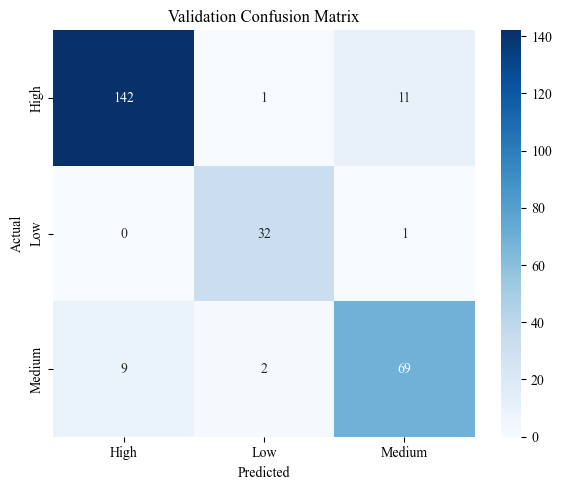

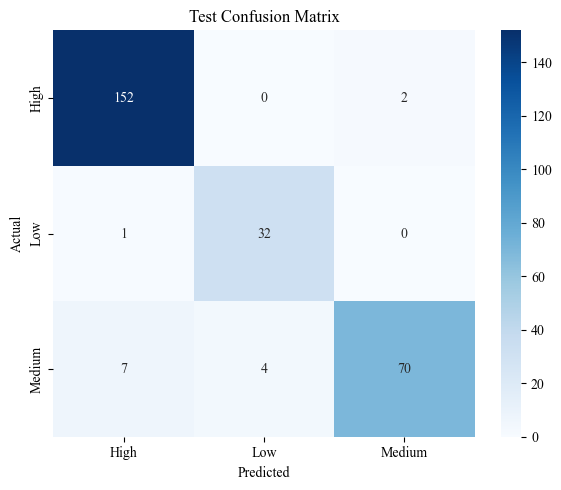

In [8]:
plot_confusion_matrix(X_valid, y_valid, "Validation", "Confusion_Matrix_Validation.png")
plot_confusion_matrix(X_test, y_test, "Test", "Confusion_Matrix_Test.png")

In [9]:
importances = clf.feature_importances_
feat_names = X.columns
topk = np.argsort(importances)[::-1]
print("All features:")
for i in topk:
    print(f"{feat_names[i]}: {importances[i]:.4f}")

All features:
CrippenLogP: 0.1621
nAcid: 0.1062
SCH-7: 0.0764
BCUTp-1h: 0.0760
maxHBa: 0.0714
MATS1s: 0.0702
minsF: 0.0651
VE1_Dzv: 0.0596
ALogP: 0.0409
minaasC: 0.0333
GATS4i: 0.0307
AATSC6v: 0.0302
VE1_Dzs: 0.0301
SpMax3_Bhs: 0.0282
VE3_Dzs: 0.0204
AATSC2m: 0.0188
minHBd: 0.0184
VR1_Dzp: 0.0111
ETA_Beta_ns_d: 0.0101
MATS6i: 0.0099
minsOH: 0.0097
VR1_D: 0.0090
ALogp2: 0.0069
ATSC1s: 0.0034
SpMin5_Bhs: 0.0015
ATSC6i: 0.0006


C:\Users\xu\AppData\Local\Temp\ipykernel_105904\449669082.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[sorted_idx], y=feat_names[sorted_idx], palette="viridis")


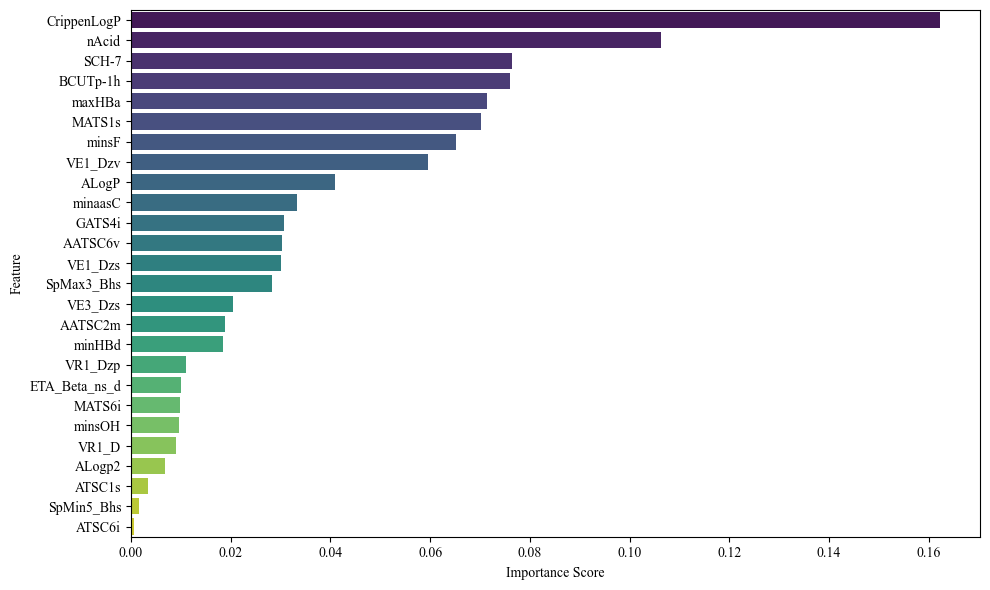

In [10]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(importances)[::-1]
sns.barplot(x=importances[sorted_idx], y=feat_names[sorted_idx], palette="viridis")

plt.title("")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("Feature Importances1.png", dpi=300, bbox_inches='tight')
plt.show()